In [87]:
!pip3 install stable-baselines3 gym pandas numpy matplotlib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [89]:
# 📌 CELL 1: Import & Setup
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Custom functions for loading LSTM
def temporal_sum(x):
    return K.sum(x, axis=1)

def attention_block_with_weights(x):
    import tensorflow as tf
    attention = tf.keras.layers.Dense(1, activation='tanh')(x)
    attention = tf.nn.softmax(attention, axis=1)
    context = attention * x
    context = tf.reduce_sum(context, axis=1)
    return context, attention


In [ ]:
# 📌 CELL 2: Load LSTM model + preprocess data
model = load_model(
    'best_lstm_attention_model.keras',
    custom_objects={
        'temporal_sum': temporal_sum,
        'attention_block_with_weights': attention_block_with_weights
    },
    safe_mode=False
)

df = pd.read_csv('ppo_ready_data.csv')  # ⬅️ replace with your actual file
SEQ_LEN = 60
selected_features = df.columns[:12]  # Adjust based on what LSTM was trained on
df = df[selected_features]

scaler = StandardScaler()
scaled = scaler.fit_transform(df)

X_res, rows = [], []
for i in range(SEQ_LEN, len(scaled)):
    X_res.append(scaled[i-SEQ_LEN:i])
    rows.append(i)
X_res = np.array(X_res)

# Predict in batches
BATCH_SIZE = 4096
pred_probs = []
for i in tqdm(range(0, len(X_res), BATCH_SIZE)):
    batch = X_res[i:i+BATCH_SIZE]
    pred_probs.append(model.predict(batch, verbose=0))
pred_probs = np.vstack(pred_probs)
pred_labels = np.argmax(pred_probs, axis=1) + 1
confidences = np.max(pred_probs, axis=1)

ppo_df = df.iloc[rows].copy().reset_index(drop=True)
ppo_df["label"] = pred_labels
ppo_df["confidence"] = confidences
ppo_df.to_csv("ppo_ready_data_PPO.csv", index=False)
print("✅ PPO-ready data saved.")


100%|██████████| 23/23 [01:44<00:00,  4.56s/it]


✅ PPO-ready data saved.


In [100]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("ppo_ready_data_PPO.csv")
df = df[df["label"].isin([1, 2])].dropna().replace([np.inf, -np.inf], 0)

# Normalize only technical features
feature_cols = [col for col in df.columns if col not in ['label', 'confidence']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], 0).fillna(0)

# Split CE and PE
ce_df = df[df["label"] == 1].reset_index(drop=True)
pe_df = df[df["label"] == 2].reset_index(drop=True)

print("✅ CE samples:", len(ce_df))
print("✅ PE samples:", len(pe_df))


✅ CE samples: 89093
✅ PE samples: 798


In [101]:
import gym
from gym import spaces
import numpy as np

# 📌 Define actions for clarity
BUY_CE = 0
BUY_PE = 1

class SuperPPOEnvDual(gym.Env):
    def __init__(self, df, signal_type='CE', lot_size=5, target=80, stoploss=40, conf_threshold=0.85):
        super(SuperPPOEnvDual, self).__init__()
        self.df = df.reset_index(drop=True)
        self.signal_type = signal_type  # 'CE' or 'PE'
        self.lot_size = lot_size
        self.target = target
        self.stoploss = stoploss
        self.conf_threshold = conf_threshold

        # 🚀 Automatically get feature columns
        self.feature_cols = df.drop(columns=["label", "confidence"]).columns.tolist()

        # 💡 PPO chooses: 0 = Take trade, 1 = Skip trade
        self.action_space = spaces.Discrete(2)

        # 🧠 Observation = features + one-hot signal + confidence
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(len(self.feature_cols) + 2 + 1,),  # features + signal(2) + confidence(1)
            dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.total_reward = 0
        self.trades = []
        return self._get_obs()

    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        confidence = np.array([row['confidence']], dtype=np.float32)

        # One-hot encode signal type
        one_hot = np.array([1, 0]) if self.signal_type == 'CE' else np.array([0, 1])

        obs = np.concatenate([features, one_hot, confidence])
        return np.nan_to_num(obs, nan=0.0, posinf=1e10, neginf=-1e10)

    def step(self, action):
        row = self.df.iloc[self.current_step]
        label = int(row['label'])
        confidence = float(row['confidence'])

        # 📌 Check label validity
        assert label in [1, 2], f"Invalid label: {label}"

        # ✅ PPO only decides: take or skip
        is_ce = self.signal_type == 'CE'
        correct_label = 1 if is_ce else 2

        if confidence < self.conf_threshold:
            reward = -5  # weak signal
        elif action == 0 and label == correct_label:
            reward = self.target
        elif action == 1 and label == correct_label:
            reward = -self.stoploss  # missed opportunity
        else:
            reward = -self.stoploss * 2  # took wrong trade

        reward *= self.lot_size
        self.total_reward += reward

        info = {
            "step": self.current_step,
            "label": label,
            "action": action,
            "confidence": confidence,
            "reward": reward
        }

        self.trades.append(info)
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._get_obs(), reward, done, info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Total ₹ Reward: {self.total_reward}")


In [102]:
df = pd.read_csv("ppo_ready_data_PPO.csv")

# 🚿 Clean it before training
df = df[df["label"].isin([1, 2])].dropna()
df = df.replace([np.inf, -np.inf], 0)
df = df.fillna(0)

feature_cols = [col for col in df.columns if col not in ['label', 'confidence']]
df[feature_cols] = (df[feature_cols] - df[feature_cols].mean()) / df[feature_cols].std()
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], 0).fillna(0)


In [103]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# ✅ CE PPO Training
ce_env = DummyVecEnv([lambda: SuperPPOEnvDual(ce_df, signal_type='CE')])
ppo_ce = PPO("MlpPolicy", ce_env, learning_rate=0.0001, batch_size=64, n_steps=2048, verbose=1)
ppo_ce.learn(total_timesteps=150_000)
ppo_ce.save("ppo_ce_model")
print("✅ Saved PPO CE model as 'ppo_ce_model.zip'")

# ✅ PE PPO Training
pe_env = DummyVecEnv([lambda: SuperPPOEnvDual(pe_df, signal_type='PE')])
ppo_pe = PPO("MlpPolicy", pe_env, learning_rate=0.0001, batch_size=64, n_steps=2048, verbose=1)
ppo_pe.learn(total_timesteps=150_000)
ppo_pe.save("ppo_pe_model")
print("✅ Saved PPO PE model as 'ppo_pe_model.zip'")


/Users/nil/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3780 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3113        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019980615 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -1.14e-05   |
|    learning_rate        | 0.0001      |
|    loss                 | 2.3e+06     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0441     |
|    value_loss           | 3.58e+06    |
-----------------------------------------
-----------------

/Users/nil/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 3789 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3196         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0060835313 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | 0.00111      |
|    learning_rate        | 0.0001       |
|    loss                 | 1.58e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00663     |
|    value_loss           | 2.24e+05     |
------------------------------------------
----------------

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_dual_ppo(df_eval, model, signal_type="CE"):
    from stable_baselines3.common.vec_env import DummyVecEnv

    env = DummyVecEnv([lambda: SuperPPOEnvDual(df_eval, signal_type=signal_type)])
    obs = env.reset()
    
    true_labels = []          # always 0: we trained on only one class (Buy CE or Buy PE)
    predicted_actions = []
    stepwise_rewards = []

    for _ in range(len(df_eval) - 1):
        action, _ = model.predict(obs)
        predicted_actions.append(int(action[0]))
        true_labels.append(0)  # all are positive signals
        obs, reward, done, _ = env.step(action)
        stepwise_rewards.append(reward[0])
        if done:
            break

    print(f"\n📊 Classification Report for PPO-{signal_type}")
    print(classification_report(true_labels, predicted_actions, target_names=[f"Buy {signal_type}", "Hold"]))

    cm = confusion_matrix(true_labels, predicted_actions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Buy {signal_type}", "Hold"],
                yticklabels=[f"Buy {signal_type}", "Hold"])
    plt.title(f"🧠 PPO-{signal_type} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.show()

    plt.plot(np.cumsum(stepwise_rewards))
    plt.title(f"📈 Cumulative PnL: PPO-{signal_type}")
    plt.xlabel("Step")
    plt.ylabel("Total ₹ Profit/Loss")
    plt.grid(True)
    plt.show()

    plt.plot(stepwise_rewards)
    plt.title(f"💵 Step-wise Rewards: PPO-{signal_type}")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.show()


/Users/nil/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



📊 Classification Report for PPO-CE
              precision    recall  f1-score   support

      Buy CE       1.00      0.93      0.96     89092
        Hold       0.00      0.00      0.00         0

    accuracy                           0.93     89092
   macro avg       0.50      0.46      0.48     89092
weighted avg       1.00      0.93      0.96     89092



/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.

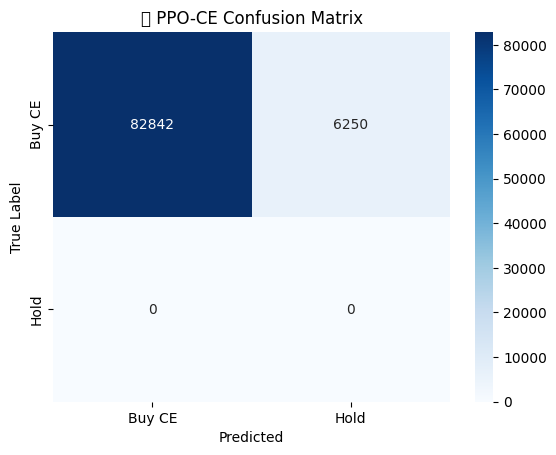

/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


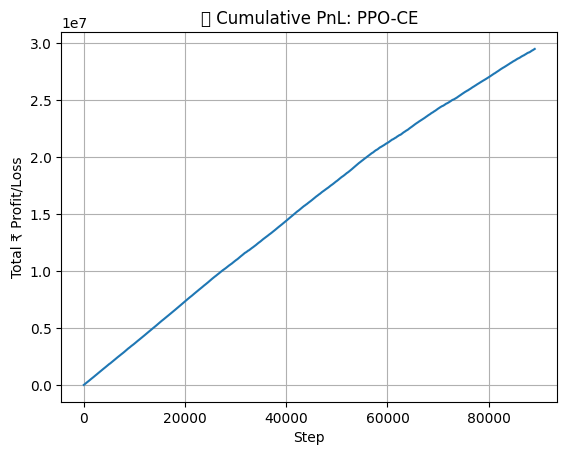

/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


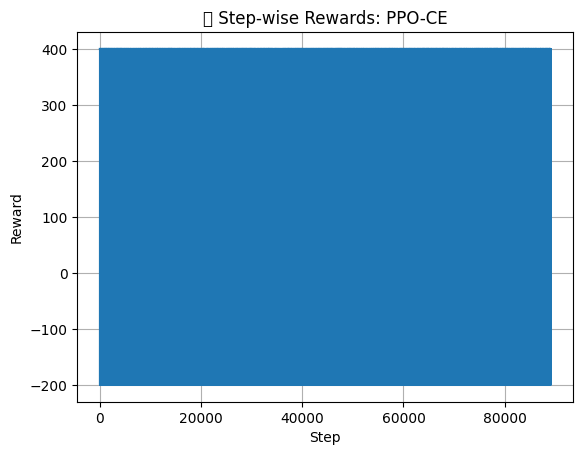

/Users/nil/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



📊 Classification Report for PPO-PE
              precision    recall  f1-score   support

      Buy PE       1.00      0.93      0.96       797
        Hold       0.00      0.00      0.00         0

    accuracy                           0.93       797
   macro avg       0.50      0.47      0.48       797
weighted avg       1.00      0.93      0.96       797



/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nil/Library/Python/3.

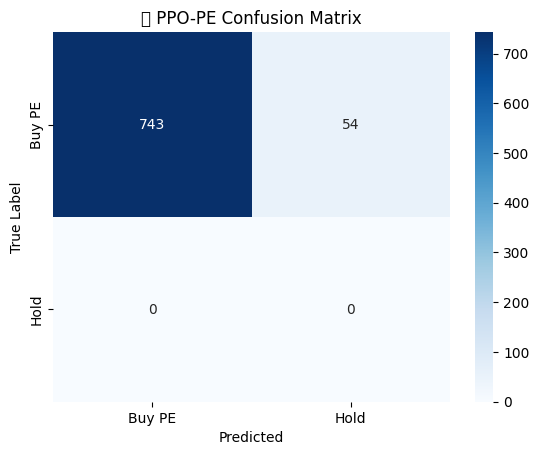

/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


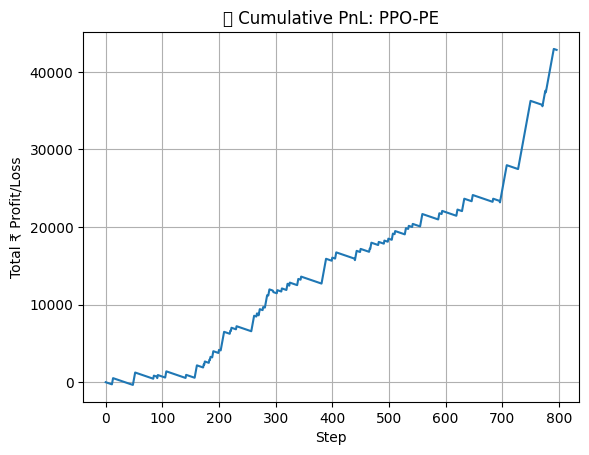

/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


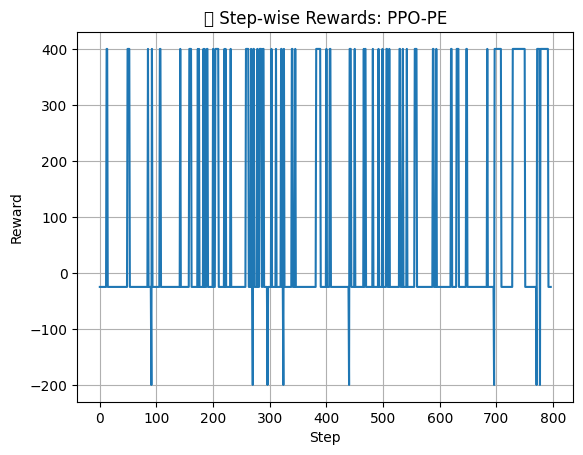

In [105]:
evaluate_dual_ppo(ce_df, ppo_ce, signal_type="CE")
evaluate_dual_ppo(pe_df, ppo_pe, signal_type="PE")
